# HMM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plugins import plot_marginal_given_data
from plugins import plot_single_trace
from plugins import plot_single_trace_grid

In [2]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [3]:
%ripl --seed 1  --plugins plugins.py

Set seed of a new VentureScript RIPL to 1.00.
Loading plugin: plugins.py


In [4]:
%%venturescript
// MODEL
assume transition_matrix = [
    simplex(.6, .1, .1, .1, .1),
    simplex(.1, .6, .1, .1, .1),
    simplex(.1, .1, .6, .1, .1),
    simplex(.1, .1, .1, .6, .1),
    simplex(.1, .1, .1, .1, .6)
];
assume e = 0.01/4.;
assume emission_matrix = [
    simplex(.99, e, e, e, e),
    simplex(e, .99, e, e, e),
    simplex(e, e, .99, e, e),
    simplex(e, e, e, .99, e),
    simplex(e, e, e, e, .99)
];
assume transition =  (state) -> {
    categorical(transition_matrix[state], arange(5))
};
assume get_state =  mem((t) -> {
    if (t <= 0) {
        integer(0)
    } else {
        transition(get_state(t - 1)) #seq:t
    }
});
assume emission = (state) -> {
    categorical(emission_matrix[state], arange(5))
};
define training_data = [0, 0, 0, 1, 1, 1, 1, 3, 3, 3];
define get_latents = () -> {
    mapv(
        (t) -> run({predict get_state(integer($t))}),
        arange(size(training_data))
    )    
};

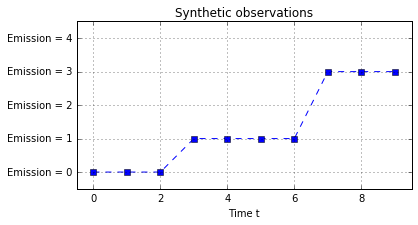

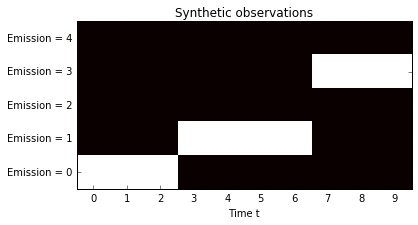

In [5]:
training_data = %venturescript training_data
_, _ = plot_single_trace(training_data, 'Synthetic observations', obs=True)
_, _ = plot_single_trace_grid(training_data, 'Synthetic observations', obs=True)

In [6]:
%%venturescript
reset_to_prior;

In [7]:
%%venturescript
// OBSERVATIONS
for_each(
    arange(size(training_data)),
    (t) -> {observe emission(get_state(integer($t))) = training_data[t];} 
);

In [8]:
%%venturescript
define number_traces = 10;
define number_replicates = 10;

In [9]:
%%venturescript
// INFERENCE
define single_site_mh  = () -> {
    mh(default, one, 1)
};

define resimulation_mh  = () -> {
    mh(default, all, 1)
};
define predict_latents = () -> {
    mapv(
        (t) -> run({predict get_state(integer($t))}),
        arange(size(training_data))
    )
};
define sample_emissions = () -> {
    mapv(
        (t) -> run({sample emission(get_state(integer($t)))}),
        arange(size(training_data))
    )
};

In [10]:
%%venturescript
define sequential_monte_carlo_resampling_at_end_only = () -> {
    resample(number_traces);
    reset_to_prior;
    for_each(
        arange(size(training_data)),
        (t) -> {observe emission(get_state(integer($t))) = training_data[t];} 
    );
    resample(1);
};
define sequential_monte_carlo_every_step = () -> {
    resample(number_traces);
    reset_to_prior;
    for_each(
        arange(size(training_data)),
        (t) -> {
            resample(number_traces);
            observe emission(get_state(integer($t))) = training_data[t];
        } 
    );
    resample(1);
};